# CSE 512 - Assignment 2

In this assignment, we will perform an analysis of a subset of the Colossal Clean Crawled Corpus (C4; [Raffel et al, 2020](https://arxiv.org/abs/1910.10683)), an unlabeled text dataset crawled from the web.
C4 is created by taking a snapshot of [Common Crawl](https://commoncrawl.org/) and open repository of web crawl data.
The clean version of this dataset contains over 100 billion words collected from over 300 million documents. This data has been used to trained many large-scale language models, such as T5 ([Raffel et al, 2020](https://arxiv.org/abs/1910.10683)) and Switch Transformers ([Fedus et al., 2021](https://arxiv.org/abs/2101.03961)), despite famously lacking thorough documentation. 

In this assignment, we will explore a subset of this enormous dataset, conducting analyses and visualizations to better understand it's shape and structure. The bulk of this data is unlabeled text, which is notoriously difficult to visualize, comprising the perfect challenge for this assignment! The data we will be working with is a random subset of the entire corpus, with 100,000 documents. We note that the entire dataset is extremely large, comprising hundreds of GBs and hundreds of billions of characters. Simply storing it would require more disk space than what is typically available for a student, and many of our explorations would be infeasible to make, especially ones that involve parsing text. We therefore focus on this random subset of the data, cautioning readers that our results should be extrapolated only with the appropriate caution. Nonetheless, we found that exploring and analysing this data led to many interesting findings, observations and visualizations, and hope our readers can enjoy the ride!

---


We start by asking three, deliberately broad questions:

1. **Where does the data come from?**
2. **When was this data written?**
3. **What is in the text?**

After an initial exploratory section, we'll discuss the motivations, implications and strategies used to answer each of these questions separately.

### Part 1 - Exploratory analysis

In this section, we will try to understand the overall shape and structure of the dataset. Let's start with some useful imports.

In [1]:
import json
import pandas as pd    
import numpy as np
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns

import socket
import requests
from tqdm.notebook import tqdm
import shapely
import geopandas
import random

%matplotlib inline

Now, let's read the data. The data comes from a json file, where each line corresponds to a document in the corpus. 

We'll read the data directly into a pandas dataframe.

In [2]:
datadir = '/home/ilharco/Desktop/cse512/A2/data/'
file_path = datadir + 'c4subset.json'
info = pd.read_json(path_or_buf=file_path, lines=True)

Now, let's take a quick glance at the structure of our data. Here, each row corresponds to a document.

In [237]:
info.head()

,text,timestamp,url
0,Beginners BBQ Class Taking Place in Missoula!\...,2019-04-25 12:57:54+00:00,https://klyq.com/beginners-bbq-class-taking-pl...
1,Discussion in 'Mac OS X Lion (10.7)' started b...,2019-04-21 10:07:13+00:00,https://forums.macrumors.com/threads/restore-f...
2,Foil plaid lycra and spandex shortall with met...,2019-04-25 10:40:23+00:00,https://awishcometrue.com/Catalogs/Clearance/T...
3,How many backlinks per day for new site?\nDisc...,2019-04-21 12:46:19+00:00,https://www.blackhatworld.com/seo/how-many-bac...
4,The Denver Board of Education opened the 2017-...,2019-04-20 14:33:21+00:00,http://bond.dpsk12.org/category/news/


There are three fields for each datapoint: 

- **text**: which contains the unlabeled text which is used for training language models.
- **timestamp**: a UTC timetamp of when the data was *collected*.
- **url**: the web url from which the text was extracted.

Let's inspect the size of our dataset, and see whether we have any empty or corrupted fields

In [238]:
num_rows = len(info)
print(f'The dataset has {num_rows} documents.\n')

fields = info.columns
is_missing = info.isna()
for field in fields:
    count = is_missing[field].value_counts()[False]
    print(f'Field "{field}" has {num_rows - count} missing inputs.')

The dataset has 100000 documents.

Field "text" has 0 missing inputs.
Field "timestamp" has 0 missing inputs.
Field "url" has 0 missing inputs.


Great, no empty data in all of the fields, whew!

Now let's take a look at the distribution of characters in the text this dataset.

In [239]:
info['text_length'] = info.apply(lambda x: len(x['text']), axis=1)

In [240]:
print(f'Total number of characters in the dataset: {sum(info["text_length"])}.')
print(f'The largest document has {max(info["text_length"])} characters.')
print(f'The smallest document has {min(info["text_length"])} characters.')
print(f'The median document has {int(np.median(info["text_length"]))} characters.')

Total number of characters in the dataset: 215377179.
The largest document has 140587 characters.
The smallest document has 25 characters.
The median document has 1141 characters.


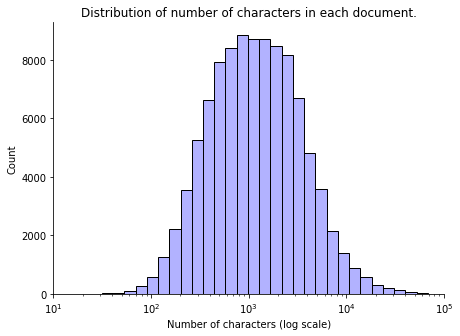

In [241]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
bins=[np.log(10**(i/20)) for i in range(40*5)]
alpha=0.3
sns.histplot(info['text_length'], log_scale=True, bins=bins, label='All', color='blue',alpha=alpha)
ax.set_xlim(10,10**5);
plt.xlabel('Number of characters (log scale)')
plt.title('Distribution of number of characters in each document.');

Alright! This data follows a smooth distribution, with a gaussian looking shape in this log scale, roughly centered around the median of slighly above 1000 characters. In total, there are over 60 million characters only in text part of this dataset!

Let's dig in deeper, counting the number of numeric, alphabetic, and ASCII characters.

In [242]:
info['text_length_numeric'] = info.apply(lambda x: sum(c.isnumeric() for c in x['text']), axis=1)
info['text_length_alpha'] = info.apply(lambda x: sum(c.isalpha() for c in x['text']), axis=1)
info['text_length_ascii'] = info.apply(lambda x: sum(c.isascii() for c in x['text']), axis=1)

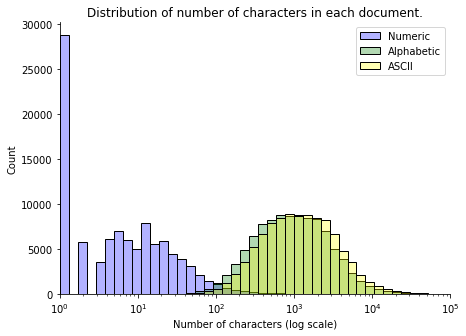

In [243]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
bins=[np.log(10**(i/20)) for i in range(40*5)]
alpha=0.3
# Note: because the text length can be 0 for some documents (which would break the log plot),
# we put all these in the first bin by setting the length to 1
def clean(series):
    series = np.array(series)
    return np.where(series > 0, series, np.ones_like(series))
sns.histplot(clean(info['text_length_numeric']), log_scale=True, bins=bins, label='Numeric', color='blue',alpha=alpha)
sns.histplot(clean(info['text_length_alpha']), log_scale=True, bins=bins, label='Alphabetic', color='green',alpha=alpha)
sns.histplot(clean(info['text_length_ascii']), log_scale=True, bins=bins, label='ASCII', color='yellow',alpha=alpha)
plt.legend()
ax.set_xlim(1,10**5);
plt.xlabel('Number of characters (log scale)')
plt.title('Distribution of number of characters in each document.');

We can see from the plot above that the number of numeric characters is considerably smaller than the others, while alphabetic characters comprise most of the ASCII characters in the dataset. Now, let's get a more general overview, for the entire dataset.

In [246]:
count_numeric = sum(info['text_length_numeric'])
count_alpha = sum(info['text_length_alpha'])
count_ascii = sum(info['text_length_ascii'])
count_other_ascii = count_ascii - count_alpha - count_numeric
count_other = sum(info['text_length']) - count_ascii

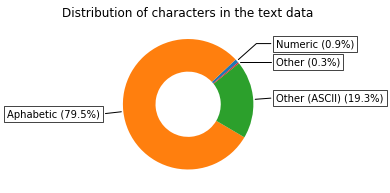

In [247]:
labels = 'Numeric', 'Aphabetic', 'Other (ASCII)', 'Other'
sizes = [count_numeric, count_alpha, count_other_ascii, count_other]
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    pct = sizes[i] / sum(sizes)
    label = f'{labels[i]} ({100*pct:.1f}%)'
    if labels[i] == 'Other':
        ax.annotate(label, xy=(x, y), xytext=(1.35*np.sign(x), 1.03*y),
                    horizontalalignment=horizontalalignment, **kw)
    else:
        ax.annotate(label, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
plt.title('Distribution of characters in the text data');

As we can see, the vast majority of characters are alphabetic, and the remaining ones are dominated by other ASCII characters, such as punctuation. The percentage of other unicode characters is very small, only 0.3% of our data.

Now, let's start exploring more deeply the contents of each of the fields of our data, and start probing our initial questions.

### Part 2 - Where does this data come from?

In this section, we will try to understand **where** our text data comes from, inspecting the urls where the text was extracted.

Understanding where our data comes from can reveal important biases in the text that we might not have been aware of, which can be reflected in the language models trained on this text.

Let's start by seeing how many of our documents comes from secure websites (with https protocols) vs ones that do not.

In [244]:
info['protocol'] = info.apply(lambda x: x['url'].split(':')[0], axis=1)

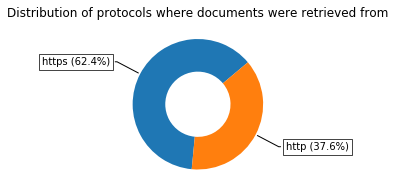

In [245]:
counts = info['protocol'].value_counts()

labels = list(counts.keys())
sizes = [counts[lbl] for lbl in labels]
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    pct = sizes[i] / sum(sizes)
    label = f'{labels[i]} ({100*pct:.1f}%)'
    ax.annotate(label, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.title('Distribution of protocols where documents were retrieved from');

Awesome, the majority of our data comes from a secure communication protocol, and all the remaining comes from the less secure version, http.

Now, let's look at the distribution of domains present in the data.

In [5]:
info['top-domain'] = info.apply(lambda x: x['url'].split('/')[2].split('.')[-1].split(':')[0], axis=1)

There are a total of 409 unique top-level domains.


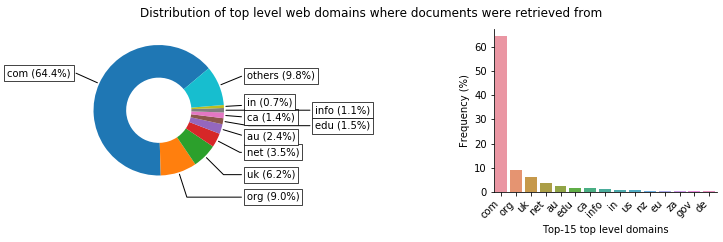

In [6]:
counts = info['top-domain'].value_counts()
print(f'There are a total of {len(counts)} unique top-level domains.')

# There might be too many domains to visualize properly, let's group the less frequent ones.
k = 9
topk_counts = counts[:k].copy()
new_row = pd.Series(data = {
    'others' : counts[k:].sum()
})
topk_counts = pd.concat([topk_counts, new_row])

labels = list(topk_counts.keys())
sizes = [topk_counts[lbl] for lbl in labels]
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
ax = axs[0]
wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    pct = sizes[i] / sum(sizes)
    label = f'{labels[i]} ({100*pct:.1f}%)'
    if labels[i] == 'in': y_m = 2.1
    else: y_m = 1.4
    if labels[i] == 'info': x_m = 2.4
    elif labels[i] == 'edu': x_m = 2.4
    else: x_m = 1.35
    ax.annotate(label, xy=(x, y), xytext=(x_m*np.sign(x), y_m*y),
                horizontalalignment=horizontalalignment, **kw)
fig.suptitle('Distribution of top level web domains where documents were retrieved from');

ax = axs[1]
sns.despine(fig)
labels = list(counts.keys())[:15]
vals = [counts[lbl] for lbl in labels]
total= sum(sizes)
vals = [100*v/total for v in vals]
sns.barplot(y=np.array(vals), x=labels, ax=ax)
ticks = [(lbl if i % 1 == 0 else '') for i, lbl in enumerate(labels)]
ax.set_xticklabels(ticks, rotation=45, ha='right')
ax.set_ylabel('Frequency (%)')
ax.set_xlabel('Top-15 top level domains')

plt.subplots_adjust(wspace=1)

Quite interesting! While ".com" represents the majority of the data, there is quite a long tail of other domains (258 in total), and the top 10 domains comprise little more than 90% of the data.

Can it be that a single website is dominating this dataset? Let's find out by taking a look at the full domain names now.

In [7]:
def get_domain(url):
    domain = url.split('/')[2].split(':')[0]
    if domain.startswith('www.'):
        domain = domain[4:]
    return domain
info['domain'] = info.apply(lambda x: get_domain(x['url']), axis=1)

counts = info['domain'].value_counts()
print(f'There are a total of {len(counts)} unique domains.')
print(f'The top-1 domain ({counts.keys()[0]}) comprises {100*counts[counts.keys()[0]]/total:.3f}% of the data.')

There are a total of 86743 unique domains.
The top-1 domain (huffpost.com) comprises 0.042% of the data.


Whoa, there's lot of domains, and the top one is only a small fraction of the total! Let's dig in more.

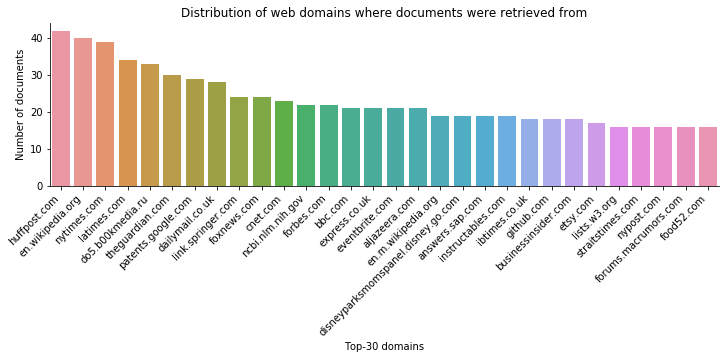

In [255]:
fig, ax = plt.subplots(figsize=(12, 3))

sns.despine(fig)
labels = list(counts.keys())[:30]
vals = [counts[lbl] for lbl in labels]
total= sum(sizes)
sns.barplot(y=np.array(vals), x=labels, ax=ax)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Top-30 domains')
ax.set_ylabel('Number of documents')

plt.subplots_adjust(wspace=1)
plt.title('Distribution of web domains where documents were retrieved from');

This seems to indicate that the distribution of domains has a very long tail, and no single website dominates the dataset! Note that the domain with the largest number of documents in this dataset has little over 40 documents, which is a tiny fraction of the overall number (0.04%). The top-30 domains contain many news websites (e.g. [Huffpost](https://www.huffpost.com/), [New York Times](https://www.nytimes.com/), [Los Angeles Times](https://www.latimes.com/), [The Guardian](https://www.theguardian.com/)), along with Wikipedia, Google's patents website, and others. Interestingly, we don't see a big presence of social media websites, including Facebook, Instagram and Reddit, which correspond to a large portion of internet traffic. 

---

Another important question in trying to understand where does this data comes from is to inspect which geolocations are represented in it. Inclusion of different regional dialects and themes is crucial for creating fair language models. As the location of the creators of the pieces of text in this data is not present, let's  estimate it using the location where the webpages are hosted. Of course, there are several caveats to working with geolocations of IP addresses, including that many websites are not hosted locally, instead being hosted in data centers; or that ISPs may store a website in different locations around the world, so a user can load a version from a nearby datacenter rather than from the original hosting location. Nonetheless, we provide our best effort at estimating geolocation below.

Given that this lookup is an expensive operation, we use only a subset of 10000 randomly sampled urls.

In [348]:
locations = pd.DataFrame(columns=['name', 'geometry'])
countries = {}
errors = set()
i = 0
urls = list(counts.keys())
random.shuffle(urls)
pbar = tqdm(urls[:10000])
for j, url in enumerate(pbar):
    try:
        ip = socket.gethostbyname(url)
        response = requests.get(f"http://geolocation-db.com/json/{ip}&position=true").json()
        lat = float(response['latitude'])
        lng = float(response['longitude'])
        country = response['country_name']
        locations.loc[i] = [url, shapely.geometry.point.Point(lng, lat)]
        i += 1
    except Exception as e:
        errors.add(url)
        country = 'Unknown'
    finally:
        if country in countries: countries[country] += counts[url]
        else: countries[country] = counts[url]
        pbar.set_description(f'Error rate: {100*len(errors)/(j+1):.2f}%')

We see that some urls (around 6%) could not be resolved into physical locations. We plot the remaining ones in a world map in Mercator Projection below

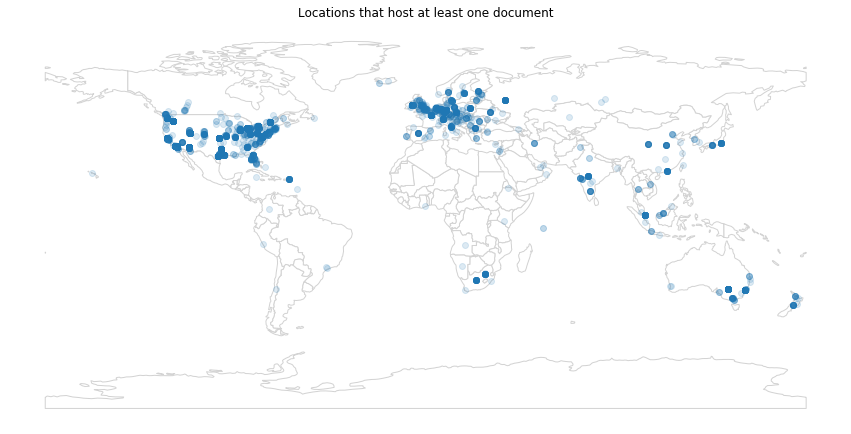

In [351]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='lightgrey')
geopandas.geodataframe.GeoDataFrame(locations).plot(ax=ax, alpha=0.15)
plt.axis('off');
plt.title('Locations that host at least one document');

In [364]:
print(f'There are {len(countries)} countries in total.')

There are 77 countries in total.


Whoa, we have data from all over the place! While Europe and the U.S. are well covered, we see domains from Chile, Russia, Brazil, India, Australia, Japan, Iceland, Angola, and many others, in a total of over 70 countries! This is awesome in terms of diversity. Now let's get a better sense of the volume that comes from each location by seeing the distribution of documents per country.

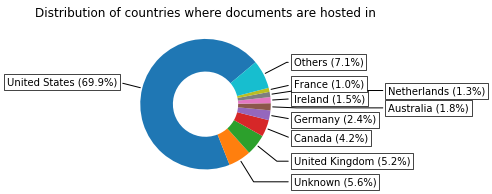

In [377]:
labels = sorted(countries.keys(), key=lambda x: -countries[x])[:]
sizes = [countries[lbl] for lbl in labels]
k = 9
other_size = sum(sizes[k:])
labels = labels[:k] + ['Others']
sizes = sizes[:k] + [other_size]

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    pct = sizes[i] / sum(sizes)
    label = f'{labels[i]} ({100*pct:.1f}%)'
    y_m = 1.4
    x_m = 1.35
    if labels[i] == 'Australia': x_m = 2.8
    elif labels[i] == 'Netherlands': x_m = 2.8
    ax.annotate(label, xy=(x, y), xytext=(x_m*np.sign(x), y_m*y),
                horizontalalignment=horizontalalignment, **kw)
plt.title('Distribution of countries where documents are hosted in');

The majority of documents are hosted in the U.S.. A significant portion (6% of documents) couldn't be resolved. There is a long tail of locations, with diverse set of countries. However, it is worth noting that many countries with English speaking populations (e.g. India, Pakistan, Nigeria, and The Philippines, with less than 1% of the documents each) are substantially underepresented in this data, in terms of number of speakers.

### Part 3 - When was this data written?

In this section, we will try to understand **when** our text data was written.

Language changes over even short timescales, and the truth or relevance of many statements depends on when they were made (e.g. who is the president of the U.S.). This has significant impact on the language models trained on this corpus.

Unfortunately, our metadata contains only the timestamp of *collection* of the data, not its creation. We start by inspecting this field.


While the actual creation date is often impossible to obtain for web documents, we use the earliest date a URL was
indexed the Internet Archive as a proxy. Note that using the Internet Archive is not perfect, as it
will sometimes index webpages many months after their creation, and many URLS are not indexed. Additionally, due to ratelimiting on the Internet Archive’s API, we'll need to estimate the date ranges using a smaller random sample of urls.

With all that considered, let's dig in!

---

First, let's inspect the timestamp we have.

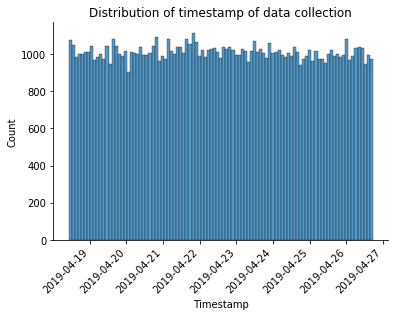

In [379]:
f, ax = plt.subplots()
sns.despine(f)
sns.histplot(info['timestamp'], bins=int((8*24+7)//2))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Timestamp')
plt.title('Distribution of timestamp of data collection');

At a high glance, this data was collected in little more than a week in April 2019. The timestamps seem pretty uniformly distributed over that range. Let's take a more finegrained look, by inspecting which part of the day our timestamps correspond to.

In [381]:
def get_hour_bin(timestamp):
    hour = timestamp.hour
    min_bin = int(timestamp.minute // 15) * 0.25
    return str(hour+min_bin)
info['hour'] = info.apply(lambda x: get_hour_bin(x['timestamp']), axis=1)

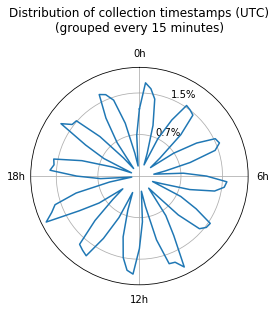

In [386]:
hour_counts_df = info['hour'].value_counts()
hour_counts = []
for hour in range(24):
    for p in [0.00, 0.25, 0.50, 0.75]:
        hour_counts.append(hour_counts_df[str(hour+p)])

total_counts = sum(hour_counts)        

f = plt.figure()
ax = f.add_subplot(111, projection='polar')

n = len(hour_counts)
angles = [i*2*np.pi/n for i in range(n)] + [0]
radii =[100*h/total_counts for h in hour_counts + [hour_counts[0]]]

ax.set_theta_zero_location("N")
ax.set_theta_direction("clockwise")
ax.set_thetagrids([0, 90, 180, 270], labels=['0h', '6h', '12h', '18h'])
ax.plot(angles, radii);
rticks = np.linspace(0, max(radii)*0.8, 3)[1:]
ax.set_yticks(rticks)
ax.set_yticklabels([f'{l:.1f}%' for l in rticks])
plt.title('Distribution of collection timestamps (UTC)\n(grouped every 15 minutes)', pad=25.0);

*Whoa!!* We have a very regular, hourly pattern, with many the number of documents rising at the beginning of an hour and taking a sharp decrease at the end. This is consistent throuhout the entire day, so we don't need to consider timezone effects.

Overall, this is quite puzzling, and I'm still unsure why exactly this is the case. My leading hypothesis is that the crawler used to collect this data get's throtolled by some websites that have hourly quotas, and this only happens in the later portion of an hour.

---

However, our main variable of interest here is not when this data was *collected*, but when it was *created*. Again, since this data is not available, we'll have to use an imperfect proxy, the date when the url was first indexed on the Internet Archive. Since this is again an expensive operation, we'll take a subset of 10,000 urls for our explorations.

In [10]:
url_counts = info['domain'].value_counts()
urls = list(url_counts.keys())
random.shuffle(urls)

In [16]:
timestamps = {}
error_count = 0.0

pbar = tqdm(urls[:10000])
for idx, url in enumerate(pbar):
    try:
        response = requests.get(f"https://archive.org/advancedsearch.php?q={url}&fl%5B%5D=date&sort%5B%5D=createdate+asc&sort%5B%5D=&sort%5B%5D=&rows=1&page=1&output=json&callback=callback&save=yes#raw")
        timestamp = pd.to_datetime(json.loads(response._content.decode('utf-8')[9:-1])['response']['docs'][0]['date'])
        timestamps[url] = timestamp
    except:
        error_count += 1
    pbar.set_description(f'Error rate: {100*error_count/(idx+1):.2f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Ooof, a >90% error rate.. Unfortunately, many of the urls in our dataset were not indexed by the Internet Achive, which limits our analyses.

However, we still have matches for hundreds of urls, let's check out what we got!

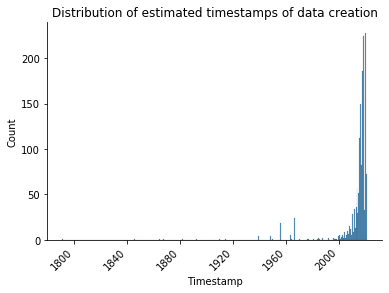

In [17]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
f, ax = plt.subplots()
sns.despine(f)
ts = []
for url, timestamp in timestamps.items():
    for _ in range(url_counts[url]):
        ts.append(timestamp)
sns.histplot(ts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Timestamp')
plt.title('Distribution of estimated timestamps of data creation');

**Whoa**, timestamp dating back to the 1800s?? These are definetely errors, unless some secret society invented computers and the internet way before we thought. This puts further into questions the reliability of the Internet Archive for estimating these creation dates. But let's keep going, we'll discard anything before the 1980s, when the internet was created.

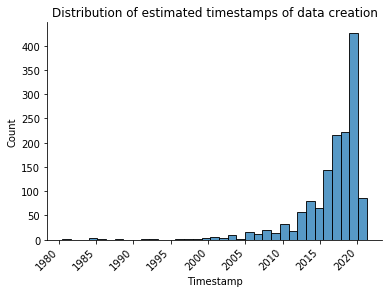

In [39]:
f, ax = plt.subplots()
sns.despine(f)
ts = []
for url, timestamp in timestamps.items():
    for _ in range(url_counts[url]):
        if timestamp > datetime.date(1980, 1, 1):
            ts.append(timestamp)
sns.histplot(ts, bins=35)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Timestamp')
plt.title('Distribution of estimated timestamps of data creation');

Ah, this is more reasonable! There are still dates that are so old they might be errors, but we see a nice increase in volume throughout the years, which corresponds to the growth of the internet. Interestingly, we also see dates after 2020, when this dataset was created in 2019, as we saw before. This is likely due to the delay in the Internet Archive in indexing these websites.

Overall, these results paint a good picture of when the data was created. We again note that it should be taken with a grain of salt, for many reasons. Firstly, it is only a subset of the data. Secondly, we are relying on the Internet Archive to estimate these timestamps since they are not present in the original dataset. The Internet Archive is very much imperfect, as we were able to find out ourselves via this inspection.

---

With that, let's move on to the fourth and final part of this assignment!

# Part 4 - What is in the text?

In this section, we will try to understand **what** is in our text data.

Now, this is by far the most challenging aspect, as visualizing text is notoriously difficult. Previous questions provides us with some clues, but there is much left unanswered.

In this section, we examine word distributions. First, we perform a frequency analyses, to find whether the distribution of words follows a [Zipfian law](https://en.wikipedia.org/wiki/Zipf%27s_law). In short, **Zipf's law** relates the rank and frequency through an inverse relation, and the Zipfian distribution is part of a family of related power law distributions. It has been extensively studied in linguistics, and can be stated, in short, as: "*the frequency of any word is inversely proportional to its rank in a frequency table*".

We use [spacy](https://spacy.io/) to split our text into words. We'll use a subsample of 10,000 documents for our analyses.

In [41]:
import spacy
nlp = spacy.load('en_core_web_sm')

word_counts = {}
for txt in tqdm(info['text'][:10000]):
    for w in nlp(txt):
        w = w.text
        w = w.strip().lower()
        if not w or not w.isalpha():
            continue
        if w not in word_counts:
            word_counts[w] = 1
        else:
            word_counts[w] += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

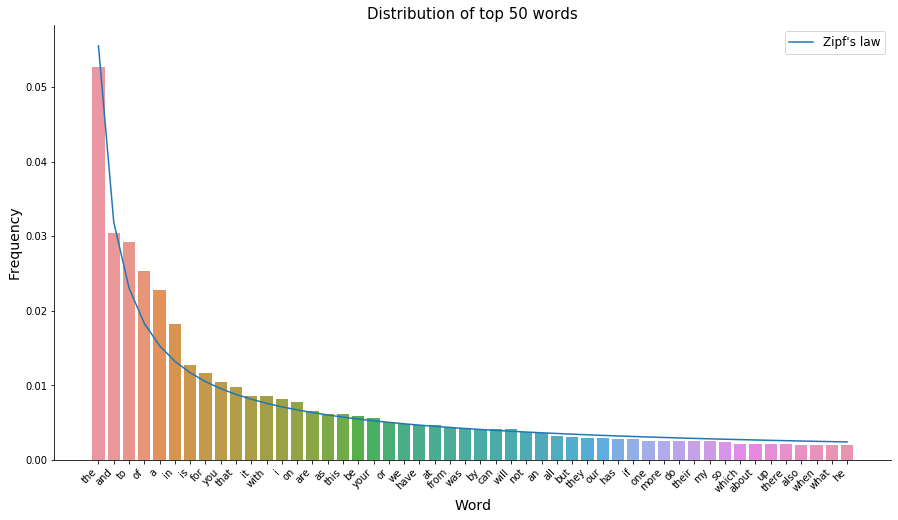

In [62]:
total_words = sum(word_counts.values())
top_k = sorted(word_counts.items(), key=lambda x: -x[1])[:50]
def get_zipf_counts(s, n, den):
    counts = [1.0/(k+1)**s/den for k in range(n)]
    return counts
zipf = get_zipf_counts(0.8, len(top_k), 18)

f, ax = plt.subplots(figsize=(15,8))
sns.despine(f)
labels, vals = zip(*top_k)
vals = [v/total_words for v in vals]
sns.barplot(y=np.array(vals), x=list(labels))
plt.plot(zipf, label='Zipf\'s law')
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of top 50 words', fontsize=15);

This is awesome, the data seems to follow Zipf's law quite closely!

However, this still doesn't give us a good sense of the content in this text, since most of the most frequent words are very generic and almost semantically void, like "the", "and", or "to". Let's try out something different, by creating a wordcloud that omits these words!

In [64]:
from wordcloud import WordCloud

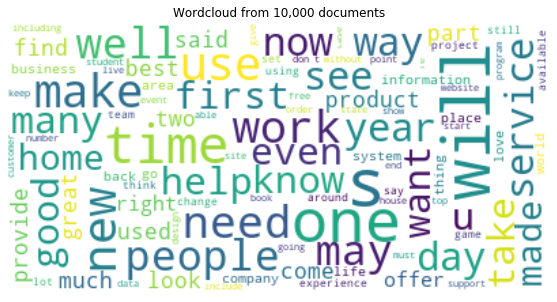

In [69]:
text = '\n'.join(info['text'][:10000])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Wordcloud from 10,000 documents');
plt.show()

Interestingly, we observe lot's of words that are common in news, but could be in many other domains as well, such as "service", "will", "provide", "time", etc. At a quick glance, this plot also seems to indicate that the language is more towards the formal side, and we do not see the presence of slangs or colloquial words.

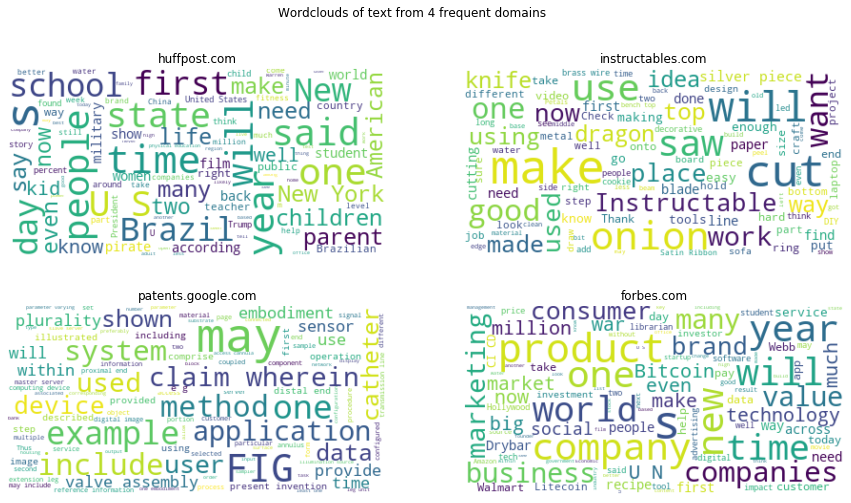

In [81]:
domains = [
    ['huffpost.com', 'instructables.com'],
    ['patents.google.com', 'forbes.com']
]

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        domain = domains[i][j]

        text = '\n'.join(info[info['domain'] == domain]['text'])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(domain)

plt.suptitle('Wordclouds of text from 4 frequent domains');

This is fascinating! It's clear that these domains contain very different language!

In huffpost.com, a news website, we can see geography-related words "US", "Brazil", "New York" occur frequently, along with some time related words (e.g. "day", "year"), and words involving quoting people (e.g. "say", "said", "according").

In instructables.com, a website that teaches people to do things, from electronics projects to carpentry and recipes, we see a lot of expected words, such as "make", "idea", "use", along with some specifics to certain kinds of instructions, such as recipe ("cut", "onion", "knife") and decoration ("dragon").

In patents.google.com, a repository of patents, we see lot's of more technical jargon, including words like "system", "application", "method", "valve". One word that particularly caught my attention was "FIG", which I didn't really know what it meant until I figured out it is used as an abbreviation for "figure" and commonly used in technical text to refer to images that accompany the text.

Finally, forbes.com is a website of a business magazine, and we again see lot's of expected words here, including "product", "company", "business", "time", "technology" and "marketing".

---

Overall, even though these collections of text are too massive for humans to comprehend, these word clouds are a great way of getting a sense of the actual content in the text.

I highly encourage you to play around with this with your own domain names, I certainly had a lot of fun myself!